
# PROCESAMIENTO DE LENGUAJE NATURAL

## Trabajo Practico 4
## Gustavo Uñapillco            a1624



## Consigna del desafío 4
  
  Construir QA Bot basado en el ejemplo del traductor pero con un dataset QA.

### 0. PIP Install e importación de datos


In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet
!pip install fasttext --quiet

In [2]:
# Importaciones de librerías estándar
import os
import platform
import logging
from pathlib import Path
from io import StringIO
import shutil
import gzip
import pickle
import re

# Importaciones de bibliotecas para el manejo de datos
import numpy as np
import pandas as pd

# Importaciones de TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Flatten, Dropout, Dense, Activation, Input
from tensorflow.keras.models import Sequential, Model

# Importaciones de bibliotecas de Machine Learning
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import plot_model


In [3]:
#Instalación de torch_helpers
if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

from torch_helpers import Tokenizer
from torch_helpers import pad_sequences


### 1. Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [5]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [6]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [7]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [8]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

In [9]:
data[0]

{'dialog': [{'id': 0,
   'sender': 'participant1',
   'text': 'hi there',
   'evaluation_score': None,
   'sender_class': 'Human'}],
 'start_time': '2018-10-29 03:32:08.296000',
 'end_time': '2018-10-29 03:32:08.296000',
 'bot_profile': ['i like to talk but people have a hard time understanding.',
  'i like to look at blocks and sing about letters.',
  'i like to eat chocolate candy.',
  'when i grow up i want to be a dog.'],
 'user_profile': ['i am a clean eater.',
  'my parents were both very athletic.',
  'i love running and preparing for marathons.',
  'i am a cancer survivor.'],
 'eval_score': None,
 'profile_match': '',
 'participant1_id': {'class': 'User', 'user_id': 'User 00172'},
 'participant2_id': {'class': 'Bot', 'user_id': 'Bot 004'}}

Recomendaciones:
- MAX_VOCAB_SIZE = 8000
- max_length ~ 10
- Embeddings 300 Fasttext
- n_units = 128
- LSTM Dropout 0.2
- Epochs 30~50


### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [10]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

#### word2idx_inputs, max_input_len

In [11]:
# Configurar el tokenizador de entrada
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

# Ajustar el tokenizador con las frases de entrada
input_tokenizer.fit_on_texts(input_sentences)

# Convertir las frases de entrada en secuencias de enteros
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

# Crear diccionario de palabras a índices
word2idx_inputs = input_tokenizer.word_index
print("\nword2idx_inputs\n\tPalabras en el vocabulario:", len(word2idx_inputs))

#Cálculo de la longitud máxima de las oraciones
max_input_len = max(len(sen) for sen in input_integer_seq)
print("\nmax_input_len\n\tSentencia de entrada más larga:", max_input_len)


word2idx_inputs
	Palabras en el vocabulario: 1799

max_input_len
	Sentencia de entrada más larga: 9


#### word2idx_outputs, max_out_len, num_words_output

In [12]:
# Configurar el tokenizador de salida
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n') # Eliminado "¿" y "<>"

# Ajustar el tokenizador con las frases de salida
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)

# Convertir las frases de salida en secuencias de enteros
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

# Crear diccionario de palabras a índices
word2idx_outputs = output_tokenizer.word_index
print("\nword2idx_outputs\n\tPalabras en el vocabulario:", len(word2idx_outputs))

# Calcular el tamaño del vocabulario de salida
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 para incluir el token de palabra desconocida
print("\nnum_words_output\n\t", num_words_output)

# Determinar la longitud máxima de una secuencia de salida
max_out_len = max(len(sen) for sen in output_integer_seq)
print("\nmax_out_len\n\tSentencia de salida más larga:", max_out_len)


word2idx_outputs
	Palabras en el vocabulario: 1806

num_words_output
	 1807

max_out_len
	Sentencia de salida más larga: 10


In [46]:
max_input_len = 5
max_out_len = 5

#### encoder_input_sequences, decoder_output_sequences, decoder_targets

In [47]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 5)
decoder_input_sequences shape: (6033, 5)


In [48]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_output_sequences shape: (6033, 5)


In [49]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 5, 1807)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [50]:
# Ruta donde se almacenará el archivo
file_path = "cc.en.300.vec.gz"

# Verificar si el archivo ya existe
if not os.path.exists(file_path):
    print("El archivo no está descargado. Procediendo a descargar...")
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
else:
    print("El archivo ya está descargado.")

El archivo ya está descargado.


In [51]:
# Ruta del archivo comprimido y descomprimido
compressed_file = 'cc.en.300.vec.gz'
decompressed_file = 'cc.en.300.vec'

# Verificar si el archivo ya está descomprimido
if not os.path.exists(decompressed_file):
    print("El archivo descomprimido no existe. Procediendo a descomprimir...")
    with gzip.open(compressed_file, 'rb') as f_in:
        with open(decompressed_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print("Archivo descomprimido correctamente.")
else:
    print("El archivo descomprimido ya existe.")

El archivo descomprimido ya existe.


In [52]:
#Convierto los embedding de formato cc.en.300.vec a cc.en.300.pickle

class WordEmbeddingsConverter:
    def __init__(self, vec_file_path, pickle_file_path, embedding_size=300):
        self.vec_file_path = vec_file_path
        self.pickle_file_path = pickle_file_path
        self.embedding_size = embedding_size

    def convert_to_pickle(self):
        # Inicializar listas para almacenar las palabras y sus embeddings
        words = []
        embeddings = []

        # Abrir el archivo .vec
        with open(self.vec_file_path, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split()
                word = parts[0]
                vector = np.array(parts[1:], dtype=np.float32)

                # Asegurarse de que el vector tiene el tamaño esperado
                if len(vector) == self.embedding_size:
                    words.append(word)
                    embeddings.append(vector)
                else:
                    print(f"Error en el vector de la palabra: {word}")

        # Convertir las listas a una estructura numpy
        embeddings_array = np.array(list(zip(words, embeddings)), dtype=[('word', 'U50'), ('embedding', np.float32, (self.embedding_size,))])

        # Guardar como archivo pickle
        with open(self.pickle_file_path, 'wb') as f_out:
            pickle.dump(embeddings_array, f_out)

        print(f"Archivo pickle guardado en: {self.pickle_file_path}")



In [53]:
# Ruta del archivo .vec y .pickle
vec_file_path = 'cc.en.300.vec'
pickle_file_path = 'cc.en.300.pickle'

# Verificar si el archivo pickle ya existe
if not os.path.exists(pickle_file_path):
    print("El archivo pickle no existe. Procediendo a convertir...")
    converter = WordEmbeddingsConverter(vec_file_path, pickle_file_path)
    converter.convert_to_pickle()
    print("Archivo .pickle generado correctamente.")
else:
    print("El archivo pickle ya existe.")

El archivo pickle ya existe.


In [54]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


In [55]:
class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'cc.en.300.pickle'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [56]:
model_embeddings = FasttextEmbeddings()  #Embedding FastText300

In [57]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [58]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(1799, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [59]:
max_input_len

5

In [60]:
n_units = 128
dropout_rate = 0.2

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable
          #trainable=True)  #probemos entrenando los embeddings

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=dropout_rate)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
#decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=2*n_units, input_length=max_out_len)

decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=dropout_rate)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="AdamW", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 5, 300)         │        539,700 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 5, 128)         │        231,296 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 128), (None,   │        219,648 │ embedding_2[0][0]      │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 5, 128),       │        131,584 │ embedding_3[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm_2[0][1],          │
│                           │ 128)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 5, 1807)        │        233,103 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,355,331 (5.17 MB)

 Trainable params: 815,631 (3.11 MB)

 Non-trainable params: 539,700 (2.06 MB)

In [61]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(1799, 300)

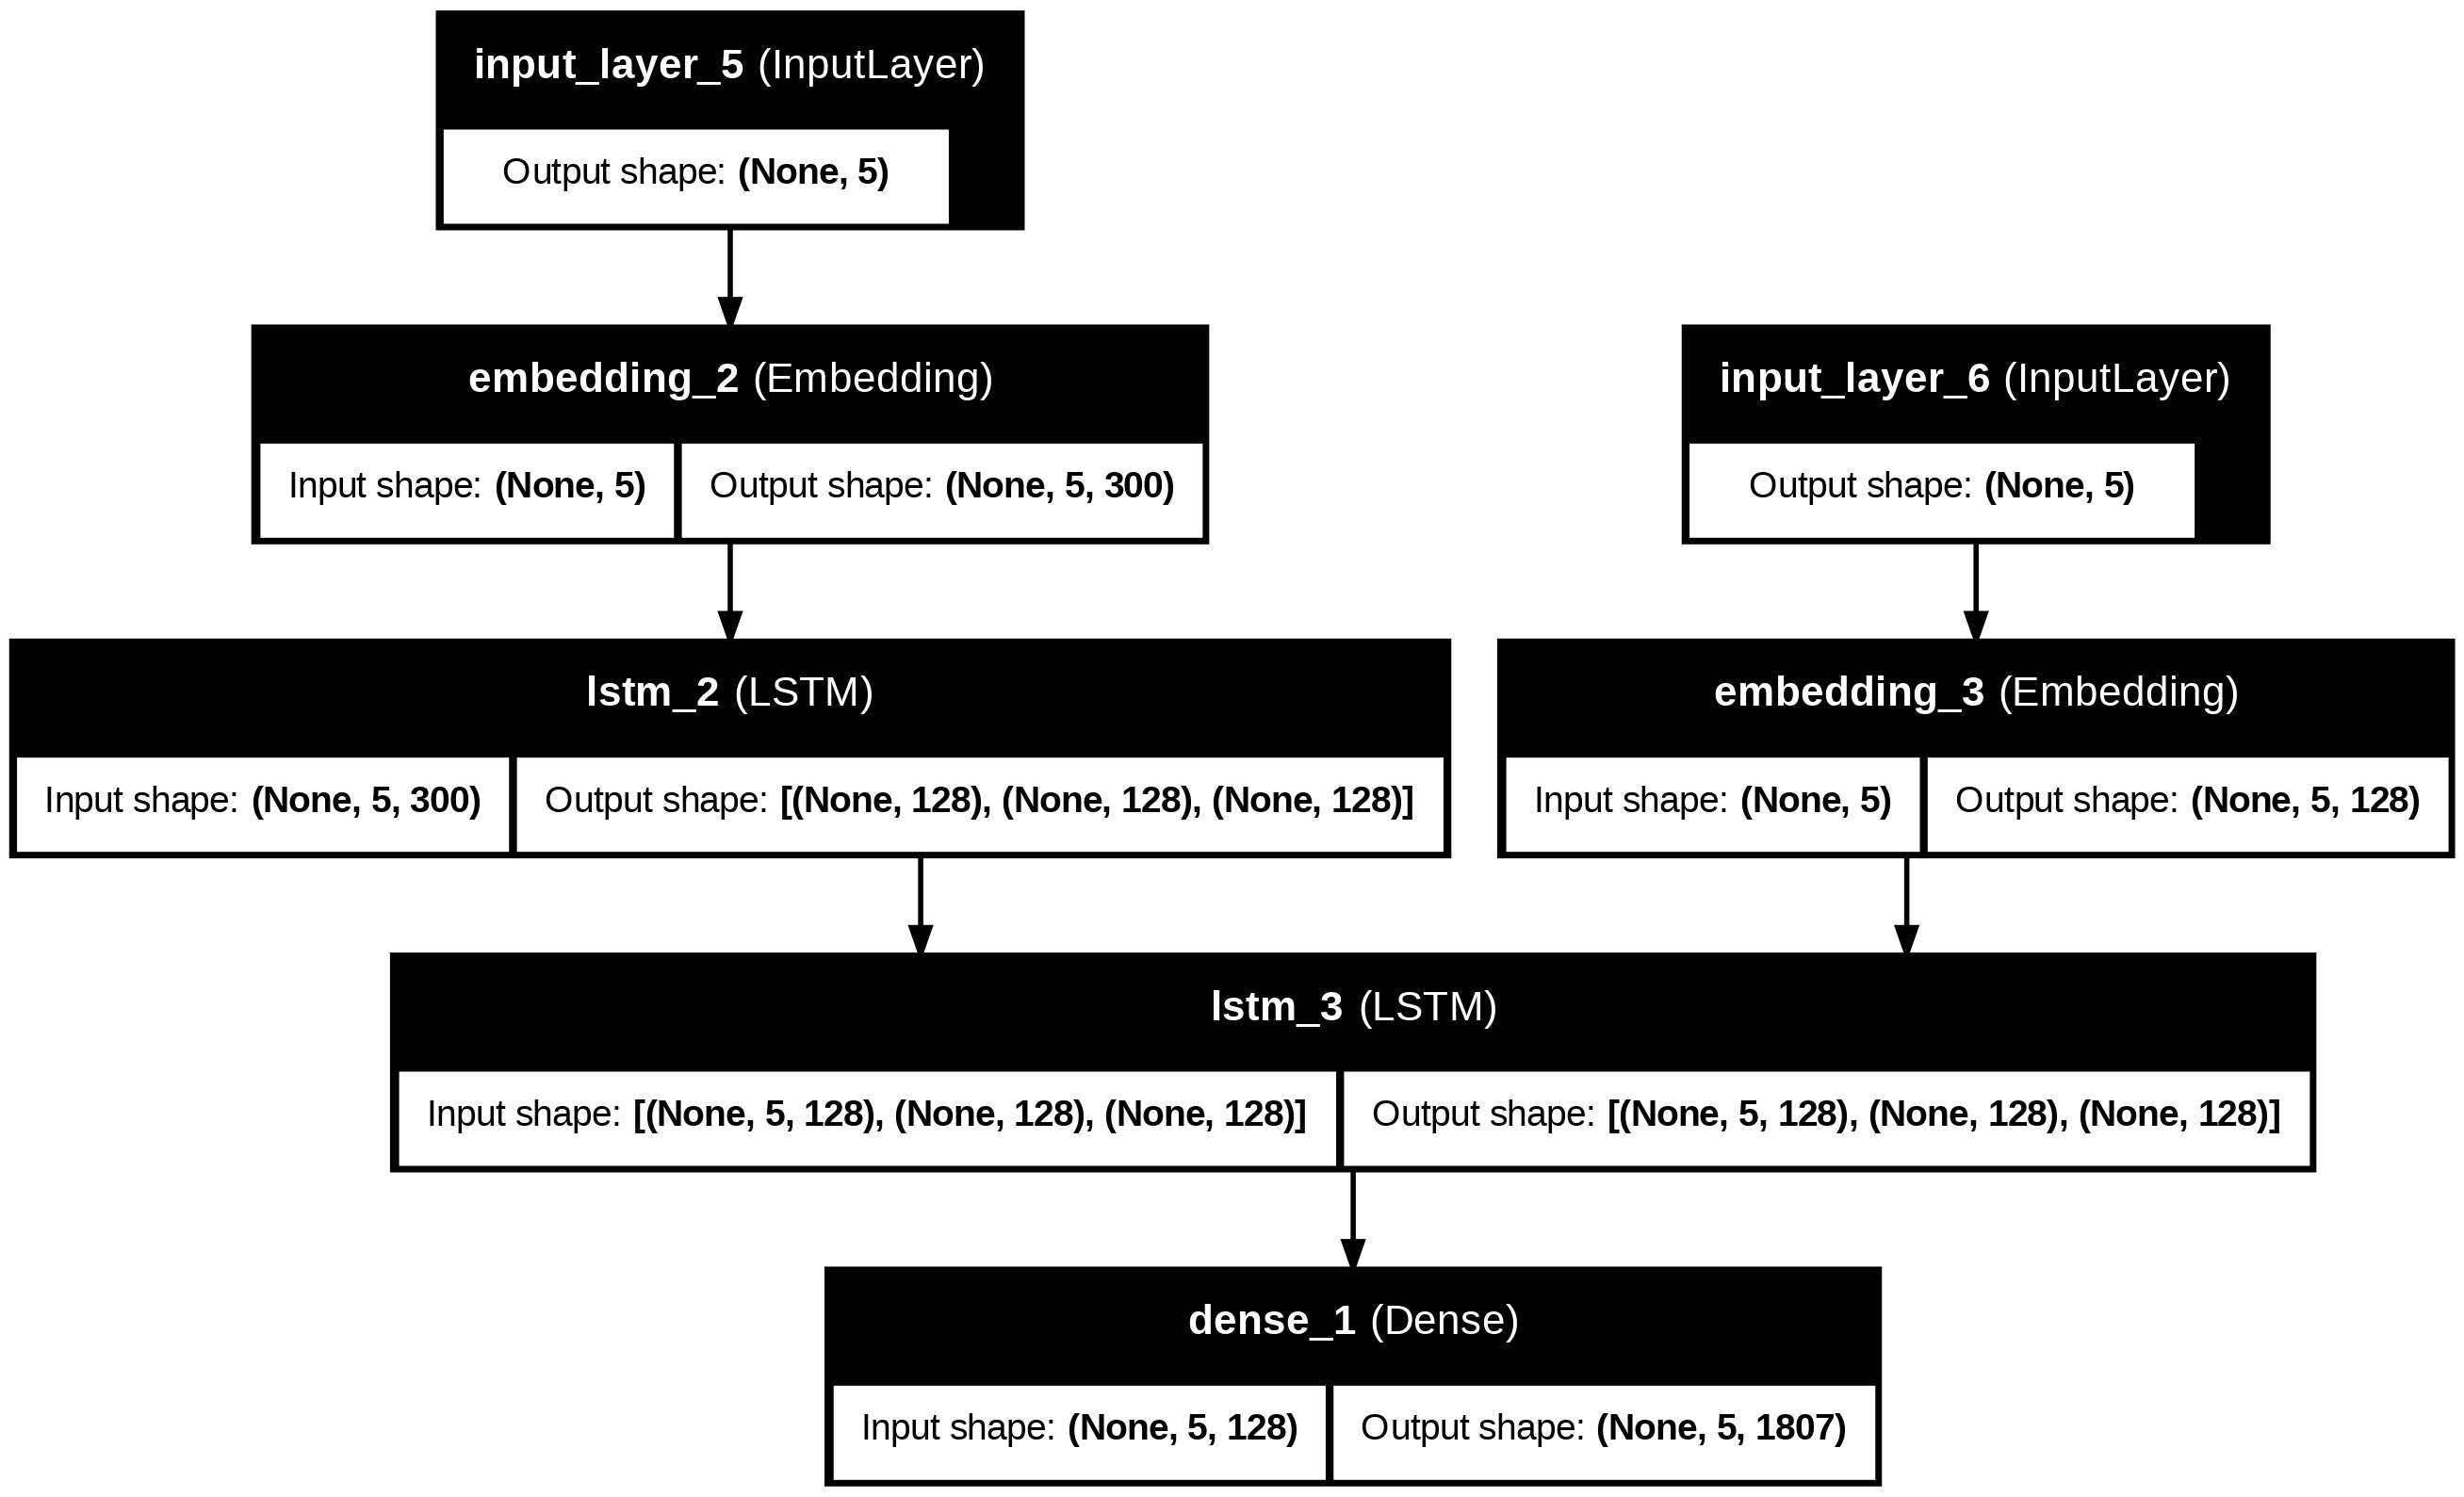

In [62]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

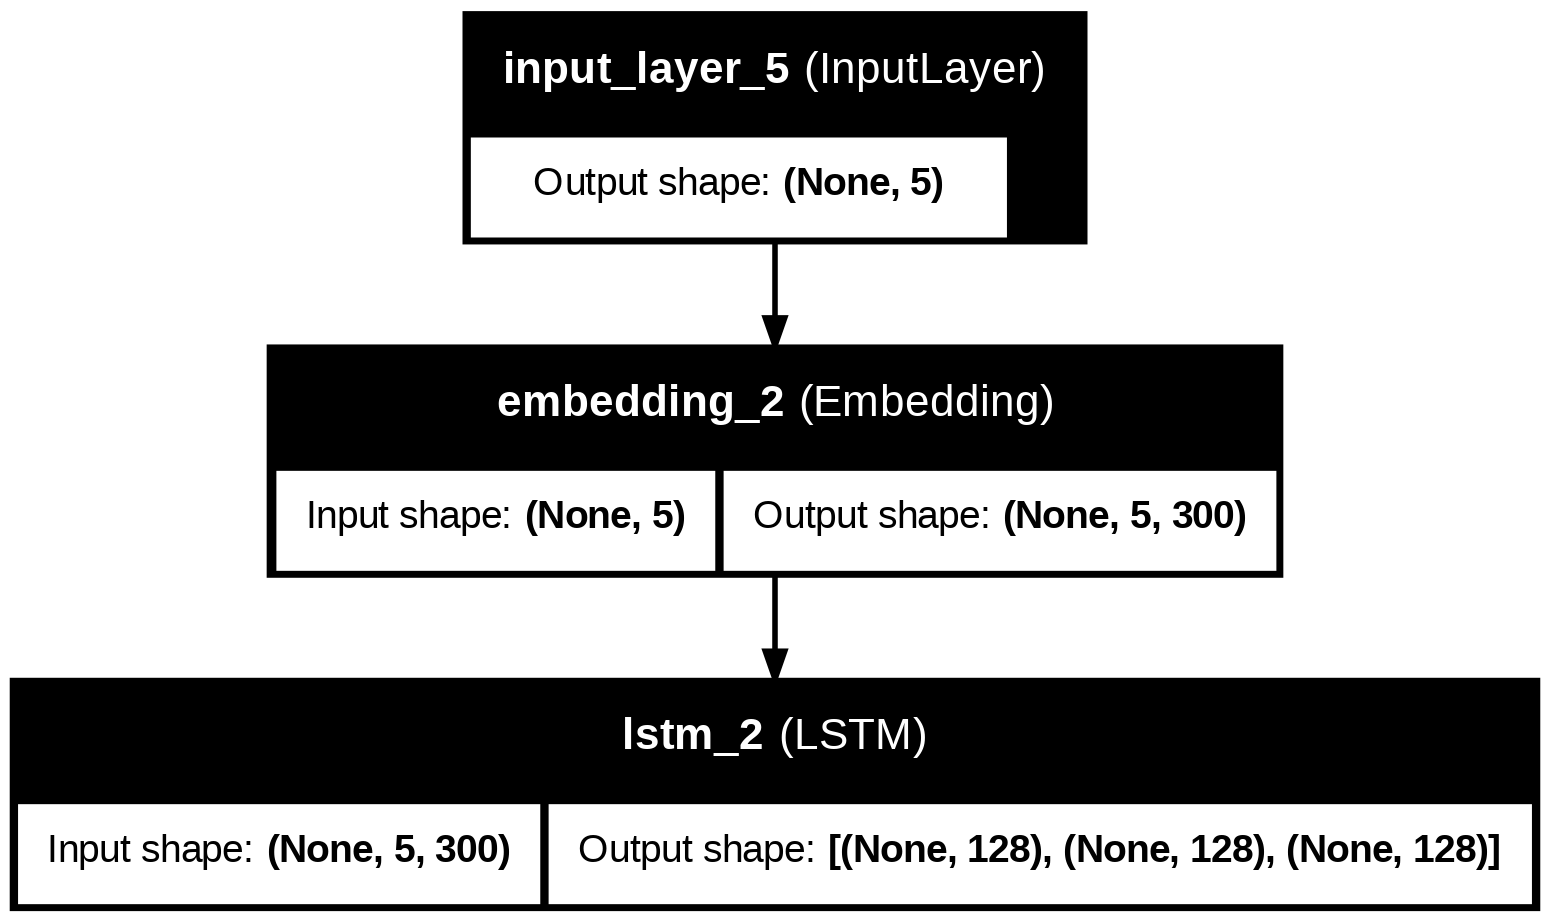

In [63]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

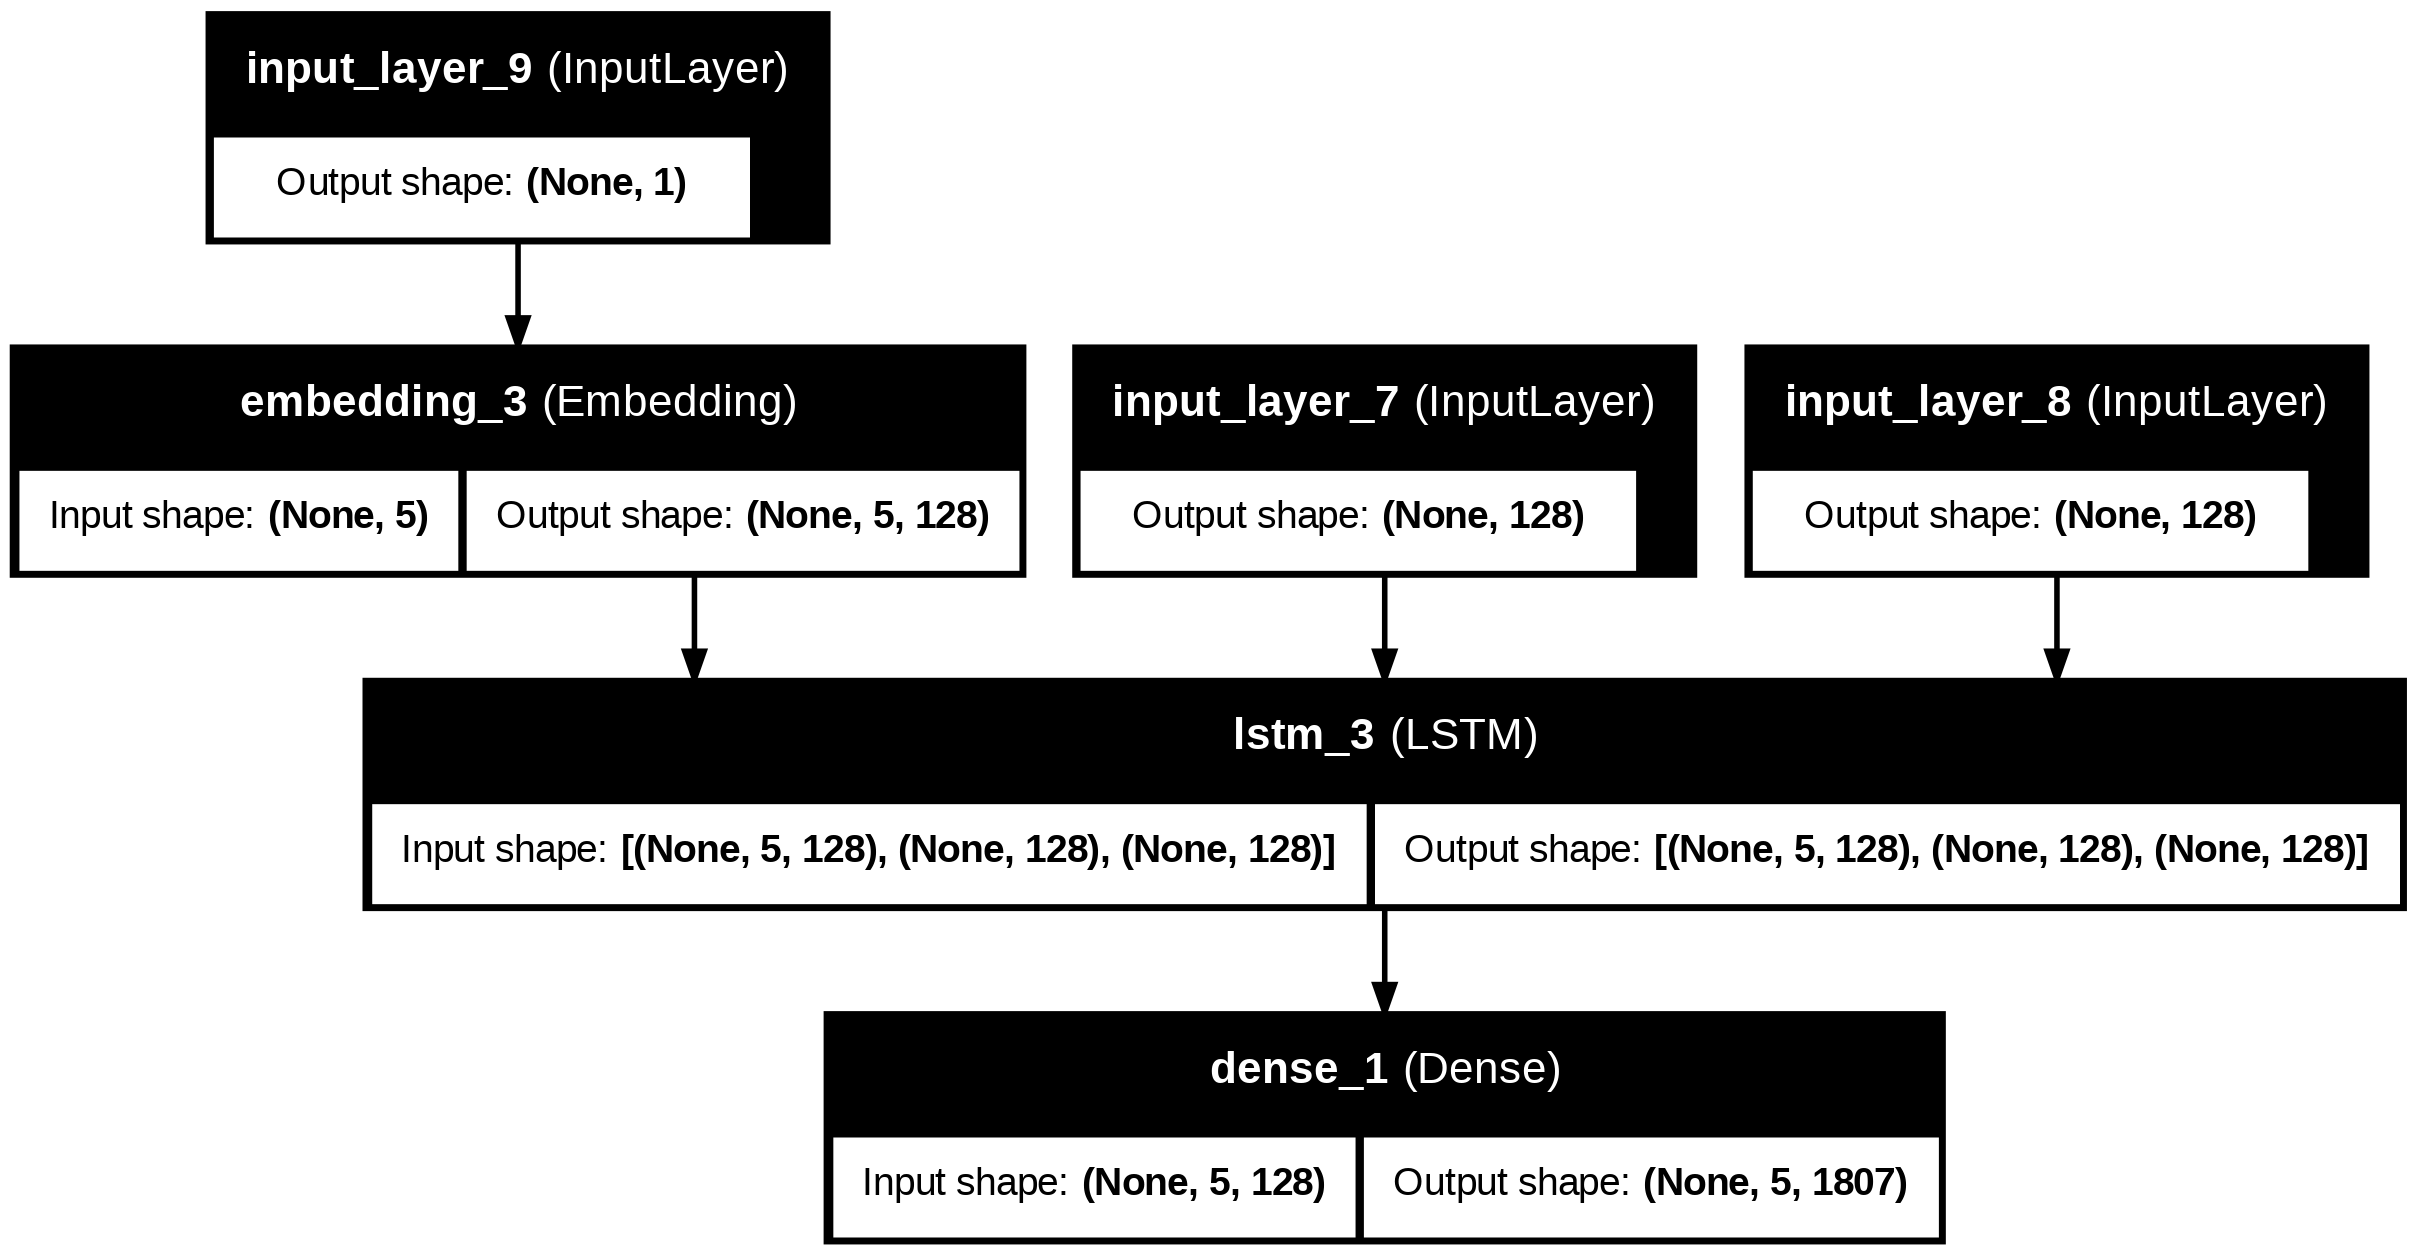

In [64]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [65]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2329 - loss: 5.2273 - val_accuracy: 0.4103 - val_loss: 3.7388
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4178 - loss: 3.3292 - val_accuracy: 0.4656 - val_loss: 3.3679
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5239 - loss: 2.8494 - val_accuracy: 0.5109 - val_loss: 3.1374
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5584 - loss: 2.5747 - val_accuracy: 0.5302 - val_loss: 3.0215
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5865 - loss: 2.3779 - val_accuracy: 0.5364 - val_loss: 2.9492
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5908 - loss: 2.2658 - val_accuracy: 0.5448 - val_loss: 2.8862
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5988 - loss: 2.1889 - val_accuracy: 0.5516 - val_loss: 2.8509
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6156 - loss: 2.0748 - val_accu

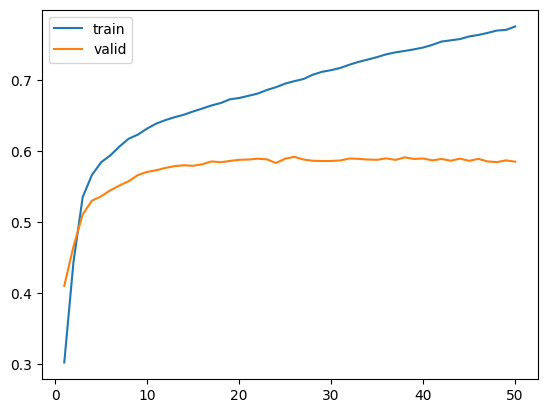

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

En un sistema QA:

Entrada (Question): El encoder procesa la pregunta formulada por el usuario.

Salida (Answer): El decoder genera una respuesta palabra por palabra, basándose en los estados generados por el encoder y en la información procesada durante el entrenamiento.

In [67]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [68]:
def answer_question(input_seq):
    """
    Función para generar una respuesta del bot QA a partir de una pregunta (input_seq).

    Args:
        input_seq (numpy array): Secuencia de índices de la pregunta.

    Returns:
        str: Respuesta generada por el modelo como una cadena de texto.
    """
    # Obtener los estados "h" y "c" de la LSTM del encoder (representación de la pregunta)
    states_value = encoder_model.predict(input_seq)

    # Inicializar la secuencia del decoder con el token de inicio <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Definir el token que indica el final de la respuesta <eos>
    eos = word2idx_outputs['<eos>']

    # Lista para almacenar las palabras de la respuesta generada
    output_sentence = []

    for _ in range(max_out_len):
        # Predicción del próximo token
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])  # Índice con mayor probabilidad

        # Si el token es <eos>, detener la generación
        if eos == idx:
            break

        # Convertir el índice a palabra
        if idx > 0:  # Ignorar índices inválidos
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados del decoder
        states_value = [h, c]

        # Actualizar la secuencia de entrada al decoder con el índice generado
        target_seq[0, 0] = idx

    # Devolver la respuesta generada como texto
    return ' '.join(output_sentence)

In [69]:
def preprocess_question(question, word2idx_inputs):
    """
    Convierte una pregunta en texto en una secuencia de índices.

    Args:
        question (str): Pregunta ingresada por el usuario.
        word2idx_inputs (dict): Diccionario que mapea palabras a índices.

    Returns:
        numpy array: Secuencia de índices representando la pregunta.
    """
    # 1. Normalizar texto (opcional, dependiendo del dataset)
    question = question.lower()  # Convertir a minúsculas
    question = question.strip()  # Eliminar espacios en los extremos
    question = question.replace("?", "")  # Eliminar el signo de interrogación

    # 2. Tokenizar el texto (dividirlo en palabras)
    tokens = question.split()  # Tokenización simple basada en espacios
    # Nota: Puedes usar bibliotecas como NLTK o spaCy para tokenización más avanzada.

    # 3. Convertir palabras a índices
    seq = [word2idx_inputs.get(word, word2idx_inputs.get('<unk>')) for word in tokens]
    # Nota: `<unk>` (unknown) es un token especial para palabras fuera del vocabulario.

    # 4. Asegurarse de que la secuencia esté en formato esperado por el modelo
    return np.array(seq).reshape(1, -1)  # Ajustar a formato (1, long_seq)

In [70]:
def bot_answer(question):
    try:
        # Preprocesar la pregunta
        input_seq = preprocess_question(question, word2idx_inputs) # Convertir pregunta a índices
        print(input_seq)
        if input_seq is None or len(input_seq[0]) == 0:
            print("Bot: Sorry, I didn’t understand the question.")
            return

        # Ajustar la secuencia al tamaño esperado por el modelo
        input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')
        print(input_seq)

        # Generar respuesta
        response = answer_question(input_seq)
        print("Bot:", response)
    except Exception as e:
        print("Error:", e)

In [71]:
bot_answer('Do you read?')

[[ 3  2 23]]
[[ 3  2 23  0  0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Bot: i love to read


In [72]:
bot_answer('Do you have a pet?')

[[  3   2  16   5 252]]
[[  3   2  16   5 252]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Bot: no


In [77]:
bot_answer('Where are you from?')

[[52  7  2 39]]
[[52  7  2 39  0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Bot: i am student


In [78]:
bot_answer('How are you?')

[[10  7  2]]
[[10  7  2  0  0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Bot: 
